In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


# Open-world Experiments - Multi-Class Classification with k-NN
- Classify 95 monitored website traces with unique labels against additional unmonitored websites.

- Monitored website instances labed with {0, 1, 2, ..., 94} and the unmonitored website instances with the label '-1'.

In [2]:
df_unmon2 = pd.read_csv("/content/drive/MyDrive/Machine Learning/팀 과제/unmon2.csv", header=None)

data preprocessing

In [3]:
df_unmon2 = df_unmon2.transpose() # transpose data
df_unmon2.rename(columns=df_unmon2.iloc[0],inplace=True)
df_unmon2 = df_unmon2.drop(df_unmon2.index[0])
df_unmon2

,total_pkt_per_user,total_outgoing_pkt_per_user,total_incoming_pkt_per_user,outgoing_pkt_frac_per_user,incoming_pkt_frac_per_user,outgoing30_per_user,incoming30_per_user,avg_total_burst_per_user,std_total_burst_per_user,max_total_burst_per_user,...,avg_sum_intervals_continuous,std_sum_intervals_continuous,max_sum_intervals_continuous,avg_outgoing_pkts_time_interval,std_outgoing_pkts_time_interval,max_outgoing_pkts_time_interval,avg_incoming_pkts_time_interval,std_incoming_pkts_time_interval,max_incoming_pkts_time_interval,flow_act_duration
1,1421.0,121.0,1300.0,0.0852,0.9148,21.0,9.0,9.1548,14.3739,66.0,...,0.0831,0.1328,0.92,0.0897,0.149,0.92,0.0766,0.1141,0.58,10.14
2,518.0,80.0,438.0,0.1544,0.8456,22.0,8.0,5.5484,9.492,50.0,...,0.1254,0.4038,3.59,0.0805,0.107,0.34,0.1715,0.5606,3.59,10.16
3,1358.0,118.0,1240.0,0.0869,0.9131,23.0,7.0,8.9801,13.9082,50.0,...,0.0934,0.2154,1.77,0.0732,0.0977,0.45,0.1139,0.2881,1.77,11.11
4,1446.0,122.0,1324.0,0.0844,0.9156,21.0,9.0,9.0881,14.3704,70.0,...,0.1086,0.1494,0.58,0.0926,0.14,0.51,0.1249,0.1568,0.58,13.36
5,1406.0,115.0,1291.0,0.0818,0.9182,22.0,8.0,8.949,13.5936,60.0,...,0.0917,0.1259,0.49,0.1091,0.1428,0.49,0.0743,0.1033,0.37,10.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28996,4593.0,413.0,4180.0,0.0899,0.9101,20.0,10.0,8.998,13.7488,69.0,...,0.0775,0.5766,11.57,0.0496,0.1286,1.6,0.0496,0.1286,1.6,32.09
28997,5110.0,447.0,4663.0,0.0875,0.9125,19.0,11.0,11.3884,16.4356,87.0,...,0.0862,0.6327,12.92,0.0588,0.2211,2.9,0.0588,0.2211,2.9,38.62
28998,361.0,59.0,302.0,0.1634,0.8366,19.0,11.0,6.4364,9.7603,41.0,...,0.5822,3.2194,25.0,0.2423,0.671,3.3,0.2423,0.671,3.3,34.93
28999,509.0,96.0,413.0,0.1886,0.8114,21.0,9.0,4.5766,7.6554,42.0,...,0.1221,0.1938,1.53,0.0869,0.0994,0.33,0.0869,0.0994,0.33,11.84


Extract X and y

In [4]:
import numpy as np
X = np.array(df_unmon2.iloc[:, 1:])
y = np.repeat(np.arange(95), 200) # add 0 ~ 94, 200 times each
y = np.append(y, np.full(10000, -1))  # add 10000 -1's

# Extract feature importance by using decision tree classifier

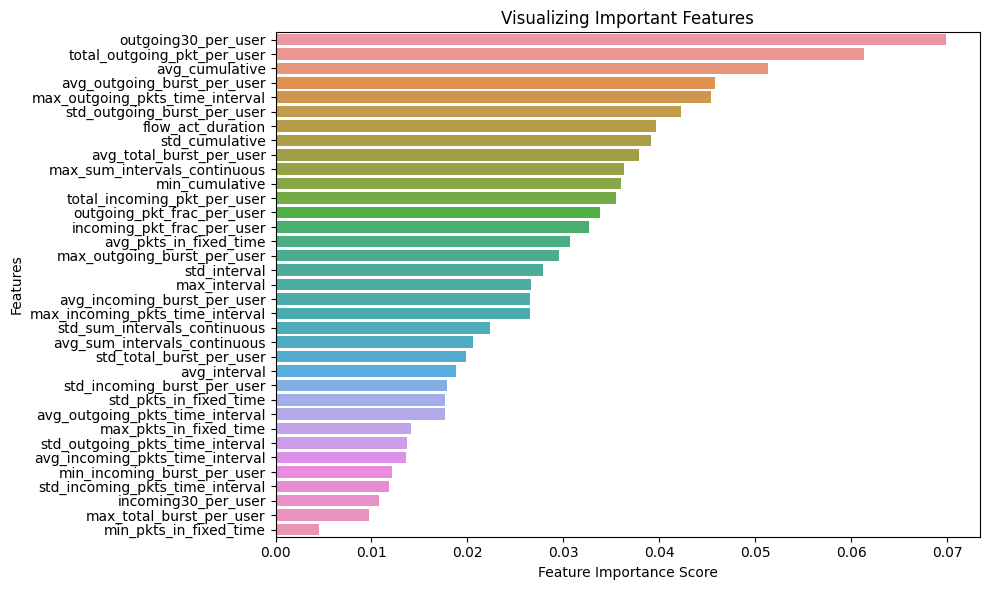

In [5]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# define Decision Tree
model = DecisionTreeClassifier()
model.fit(X, y)

# feature importance
importance = model.feature_importances_

# visualize feature importance
feature_imp = pd.Series(importance, index=df_unmon2.iloc[:, 1:].columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

# function for k-NN with GridSearch with n most important features

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
import time
import math

def kNN_grid_top_n(top_n):
  # extract n most important features
  X = np.array(df_unmon2[feature_imp.index[:top_n]])

  # split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Normalization
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # KNN with GridSearch
  param_grid = {'n_neighbors': [3, 5, 7], 'metric' : ['euclidean', 'manhattan', 'minkowski']}
  grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)  # 5-fold cross validation
  grid.fit(X_train, y_train)

  # best accuracy and parameters
  print('Best accuracy :', grid.best_score_)
  print("Best parameters:", grid.best_params_)

  # performance
  pred = grid.best_estimator_.predict(X_test)
  print("\n[Performance]")
  print("accuracy:",accuracy_score(y_test, pred))
  print("recall:",recall_score(y_test, pred, average='weighted'))
  print("precision:",precision_score(y_test, pred, average='weighted'))

# 1. k-NN with all 36 features

In [7]:
kNN_grid_top_n(36)

Best accuracy : 0.6974568965517242
Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}

[Performance]
accuracy: 0.704655172413793
recall: 0.704655172413793
precision: 0.7009849256682342


# 2. k-NN with 5 most important features

In [8]:
kNN_grid_top_n(5)

Best accuracy : 0.5607327586206896
Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}

[Performance]
accuracy: 0.5724137931034483
recall: 0.5724137931034483
precision: 0.5629231244273057


# 3. k-NN with the 25 most important features

In [9]:
kNN_grid_top_n(25)

Best accuracy : 0.7125431034482759
Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}

[Performance]
accuracy: 0.7122413793103448
recall: 0.7122413793103448
precision: 0.7125114923561343
